 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [1]:
import numpy as np
import pandas as pd
import gc
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from catboost.utils import get_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
# Functions

# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def build_roc(target_test,test_preds):
    fpr, tpr, threshold = roc_curve(target_test, test_preds)
    
    # plot the no skill line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the ro curve 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def make_classification_report(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()
    
    target_names = y.unique().tolist()
    for i in range(len(target_names)):
        target_names[i] = str(target_names[i])
    print(classification_report(y_test, y_pred, target_names=target_names))

def plot_feature_importance(clf, training_set: pd.DataFrame):
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, training_set.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:30])
    plt.title('XGB Most Important Features')
    plt.tight_layout()
    plt.show()

## Load the Dataset

In [3]:
FOLDER_PATH = 'data'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [4]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

Click [here](https://github.com/JoshSpangler96/IEEE-CIS-Fraud-Detection/blob/main/IEEE_Fraud_Detection_EDA.ipynb) to view the EDA I performed for this dataset \
\
Key takeaways from EDA: 
* Highly imbalanced dataset with 3.5% fraud
* Train data and test data are seperated by time. Need time based split for validation set
* Ff the 415 features in the V, C, D, M, and ID categories there are 136 uncorrelated useful features
* Highest precentage of Fraud happens early morning

In [8]:
test.columns = test.columns.str.replace('[-]', '_')

In [9]:
# Keep only the useful columns from the EDA
features_to_use = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceType', 
    'DeviceInfo', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 
    'V147', 'V142', 'V1', 'V174', 'V109', 'V201', 'V238', 'V271', 'V78', 
    'V160', 'V65', 'V339', 'V27', 'V138', 'V320', 'V6', 'V223', 'V114', 
    'V118', 'V173', 'V80', 'V107', 'V258', 'V44', 'V198', 'V252', 'V220', 
    'V309', 'V209', 'V67', 'V124', 'V260', 'V155', 'V176', 'V55', 'V36', 
    'V325', 'V127', 'V175', 'V82', 'V20', 'V329', 'V111', 'V139', 'V210', 
    'V30', 'V86', 'V3', 'V37', 'V13', 'V207', 'V286', 'V47', 'V162', 'V8', 
    'V62', 'V234', 'V56', 'V240', 'V23', 'V4', 'V115', 'V166', 'V121', 'V76', 
    'V259', 'V312', 'V120', 'V169', 'V305', 'V291', 'V185', 'V26', 'V241', 
    'V250', 'V108', 'V261', 'V54', 'D5', 'D14', 'D1', 'D9', 'D13', 'D8', 
    'D15', 'D10', 'C1', 'C5', 'C3', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 
    'M1', 'M3', 'M8', 'id_08', 'id_09', 'id_28', 'id_07', 'id_37', 'id_01', 
    'id_27', 'id_25', 'id_21', 'id_12', 'id_38', 'id_35', 'id_30', 'id_04', 
    'id_05', 'id_29', 'id_36', 'id_34', 'id_11', 'id_26', 'id_13', 'id_24', 
    'id_23', 'id_20', 'id_17', 'id_14', 'id_31', 'id_32', 'id_03', 'id_10', 
    'id_18', 'id_02', 'id_06', 'id_16', 'id_15', 'id_19', 'id_33', 'id_22']

#reduce both test and train
print(f'Datasets have {len(train.columns)} features before reduction')
train_features = features_to_use + ['isFraud']
train = train[train_features]
test = test[features_to_use]
print(f'Datasets have {len(train.columns)} features after reduction')

Datasets have 434 features before reduction
Datasets have 155 features after reduction


## Feature Engineering

In [10]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

datasets = [train, test]
for data in datasets:
    data['cents'] = (data['TransactionAmt'] - np.floor(data['TransactionAmt'])).astype('float32')
    data['log_TransactionAmt'] = np.log(data['TransactionAmt'])
    data[['P_email_1', 'P_email_2', 'P_email_3']] = data['P_emaildomain'].str.split('.', expand=True)
    data.drop('P_emaildomain', axis=1, inplace=True)
    data[['R_email_1', 'R_email_2', 'R_email_3']] = data['R_emaildomain'].str.split('.', expand=True)
    data.drop('R_emaildomain', axis=1, inplace=True)
    data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    data['Weekdays'] = data['Date'].dt.dayofweek
    data['Hours'] = data['Date'].dt.hour
    data['Days'] = data['Date'].dt.day
    data['Month'] = (data['Date'].dt.year-2017)*12 + data['Date'].dt.month
    
    # Aggregate features together
    data['uid'] = data['card1'].astype(str)+'_'+data['addr1'].astype(str)
    data['uid2'] = data['uid'].astype(str)+'_'+np.floor(data.Days-data.D1).astype(str)
    for feature in ['TransactionAmt', 'D9', 'D10', 'C1', 'C5']:
        for agg in ['mean', 'std']:
            temp = data.groupby(['uid2'])[feature].agg([agg]).reset_index().rename(columns={f'{agg}': f'{feature}_{agg}_uid'})
            temp.index = list(temp['uid2'])
            temp = temp[f'{feature}_{agg}_uid'].to_dict()
            data[f'{feature}_{agg}_uid'] = data['uid2'].map(temp).astype('float32')
    data.drop('uid2', axis=1, inplace=True)       
    
    
print(f'Datasets have {len(train.columns)} features after feature engineering')

Datasets have 177 features after feature engineering


## Prepare for Modeling

***Categorical Feature Encoding***

In [11]:
# get a list of all categorical features in the datasets
d_type = pd.DataFrame(train.dtypes)
d_type.rename({0: 'dtype'}, axis=1,  inplace=True)
d_type.reset_index(inplace=True)
d_type['dtype'] = d_type['dtype'].astype('string')
cat_col = d_type.loc[(d_type['dtype'] != 'int64') &\
                     (d_type['dtype'] != 'float64') &\
                     (d_type['dtype'] != 'datetime64[ns]')]['index'].to_list()

print(cat_col)

['ProductCD', 'card4', 'card6', 'DeviceType', 'DeviceInfo', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 'M1', 'M3', 'M8', 'id_28', 'id_37', 'id_27', 'id_12', 'id_38', 'id_35', 'id_30', 'id_29', 'id_36', 'id_34', 'id_23', 'id_31', 'id_16', 'id_15', 'id_33', 'cents', 'P_email_1', 'P_email_2', 'P_email_3', 'R_email_1', 'R_email_2', 'R_email_3', 'uid', 'TransactionAmt_mean_uid', 'TransactionAmt_std_uid', 'D9_mean_uid', 'D9_std_uid', 'D10_mean_uid', 'D10_std_uid', 'C1_mean_uid', 'C1_std_uid', 'C5_mean_uid', 'C5_std_uid']


In [12]:
for i in range(len(cat_col)):
    if cat_col[i] in train.columns:
        le = LabelEncoder()
        le.fit(list(train[cat_col[i]].astype(str).values) + list(test[cat_col[i]].astype(str).values))
        train[cat_col[i]] = le.transform(list(train[cat_col[i]].astype(str).values))
        test[cat_col[i]] = le.transform(list(test[cat_col[i]].astype(str).values))   

***Clean Missing Values***

In [13]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

***Reduce Memory Usage***

In [15]:
# set up X train and y train
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'Date'], axis=1)

In [16]:
# reduce the memory usage
X = reduce_mem_usage2(X)

Memory usage of dataframe is 682.58 MB
Memory usage after optimization is: 192.61 MB
Decreased by 71.8%


In [17]:
del train
gc.collect()

29

### Modeling

In [18]:
ind_train = len(X)*0.75
X_train = X.loc[:ind_train]
y_train = y.loc[:ind_train]
X_test = X.loc[ind_train:]
y_test = y.loc[ind_train:]

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [20]:
# Parameter grid for lgb
params = {
    'learning_rate': [0.01, 0.02],
    'min_child_weight': [0.001, 0.01],
    'colsample_bytree': [0.5, 0.7],
    'num_leaves': [256, 512],
    'feature_fraction': [0.5, 0.75],
    'bagging_fraction': [0.5, 0.75],
    'reg_alpha': [0.4, 0.6],
    'reg_lambda': [0.4, 0.6],
}

lgb_clf = lgb.LGBMClassifier(
    learning_rate=0.02, 
    n_estimators=600, 
    objective='binary',
    metric= 'auc',
    n_jobs = -1
)

param_comb = 5

clf = RandomizedSearchCV(
    lgb_clf, 
    param_distributions=params,         
    n_iter=param_comb, scoring='roc_auc',             
    n_jobs=4, 
    cv=3
)

clf.fit(X_sm, y_sm, verbose=200, eval_set=[(X_test, y_test)])

print('\n Best hyperparameters:')
print(clf.best_params_)
print('\n Best estimator:')
print(clf.best_estimator_)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[200]	valid_0's auc: 0.948434	valid_1's auc: 0.880475
[400]	valid_0's auc: 0.98909	valid_1's auc: 0.904562
[600]	valid_0's auc: 0.99904	valid_1's auc: 0.910757

 Best hyperparameters:
{'reg_lambda': 0.4, 'reg_alpha': 0.6, 'num_leaves': 512, 'min_child_weight': 0.001, 'learning_rate': 0.02, 'feature_fraction': 0.5, 'colsample_bytree': 0.7, 'bagging_fraction': 0.75}

 Best estimator:
LGBMClassifier(bagging_fraction=0.75, colsample_bytree=0.7,
               feature_fraction=0.5, learning_rate=0.02, metric='auc',
               n_estimators=600, num_leaves=512, objective='binary',
               reg_alpha=0.6, reg_lambda=0.4)


In [26]:
# Obtained through RandomSearchCV
hyper_parameters = {
    'num_leaves': 512, 
    'min_child_weight': 0.001,
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.75,
    'min_data_in_leaf': 106,
    'objective': 'binary',
    'learning_rate': 0.02, 
    'boosting_type': 'gbdt',
    'metric': 'auc',
    "verbosity": -1,
    'reg_lambda': 0.4, 
    'reg_alpha': 0.6, 
}

Training on fold 1 (Withholding Month: 12)
Train size: 456201 Test Size: 134339
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.9904	valid_1's auc: 0.873621
[400]	training's auc: 0.997893	valid_1's auc: 0.885155
[600]	training's auc: 0.999266	valid_1's auc: 0.888394
[800]	training's auc: 0.999656	valid_1's auc: 0.890623
[1000]	training's auc: 0.999812	valid_1's auc: 0.891583
[1200]	training's auc: 0.999883	valid_1's auc: 0.892178
[1400]	training's auc: 0.99992	valid_1's auc: 0.89218
[1600]	training's auc: 0.999942	valid_1's auc: 0.892242
[1800]	training's auc: 0.999955	valid_1's auc: 0.89223
[2000]	training's auc: 0.999964	valid_1's auc: 0.892118
Early stopping, best iteration is:
[1644]	training's auc: 0.999945	valid_1's auc: 0.892427
Training Set Classification Report


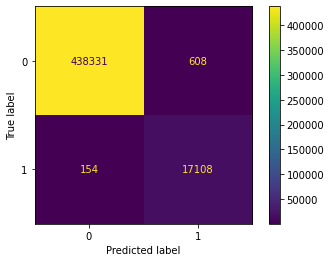

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    438939
           1       0.97      0.99      0.98     17262

    accuracy                           1.00    456201
   macro avg       0.98      0.99      0.99    456201
weighted avg       1.00      1.00      1.00    456201

Validation Set Classification Report


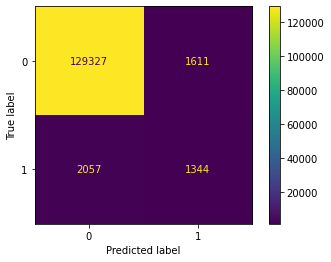

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    130938
           1       0.45      0.40      0.42      3401

    accuracy                           0.97    134339
   macro avg       0.72      0.69      0.70    134339
weighted avg       0.97      0.97      0.97    134339



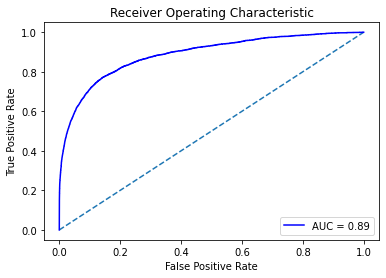

Training on fold 2 (Withholding Month: 15)
Train size: 488572 Test Size: 101968
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.990735	valid_1's auc: 0.914923
[400]	training's auc: 0.998122	valid_1's auc: 0.918719
[600]	training's auc: 0.999341	valid_1's auc: 0.919132
[800]	training's auc: 0.999707	valid_1's auc: 0.918743
Early stopping, best iteration is:
[469]	training's auc: 0.998758	valid_1's auc: 0.919349
Training Set Classification Report


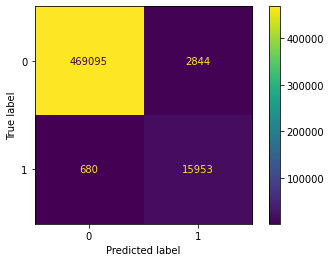

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    471939
           1       0.85      0.96      0.90     16633

    accuracy                           0.99    488572
   macro avg       0.92      0.98      0.95    488572
weighted avg       0.99      0.99      0.99    488572

Validation Set Classification Report


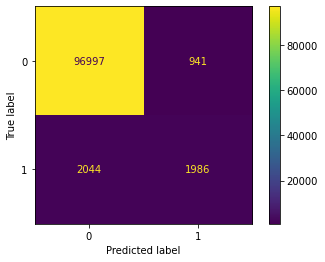

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     97938
           1       0.68      0.49      0.57      4030

    accuracy                           0.97    101968
   macro avg       0.83      0.74      0.78    101968
weighted avg       0.97      0.97      0.97    101968



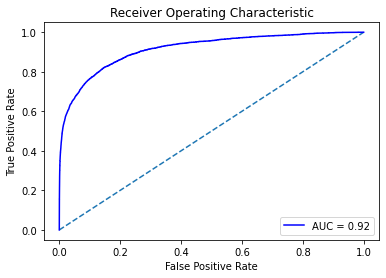

Training on fold 3 (Withholding Month: 13)
Train size: 498030 Test Size: 92510
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.989907	valid_1's auc: 0.923307
[400]	training's auc: 0.997936	valid_1's auc: 0.929545
[600]	training's auc: 0.999314	valid_1's auc: 0.930498
[800]	training's auc: 0.99969	valid_1's auc: 0.930608
[1000]	training's auc: 0.999836	valid_1's auc: 0.930141
[1200]	training's auc: 0.999898	valid_1's auc: 0.929318
Early stopping, best iteration is:
[776]	training's auc: 0.999662	valid_1's auc: 0.930659
Training Set Classification Report


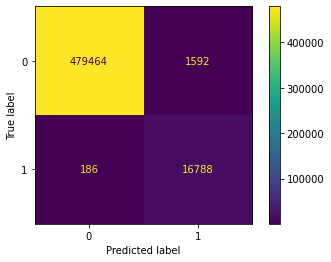

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    481056
           1       0.91      0.99      0.95     16974

    accuracy                           1.00    498030
   macro avg       0.96      0.99      0.97    498030
weighted avg       1.00      1.00      1.00    498030

Validation Set Classification Report


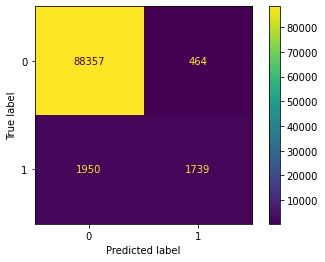

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     88821
           1       0.79      0.47      0.59      3689

    accuracy                           0.97     92510
   macro avg       0.88      0.73      0.79     92510
weighted avg       0.97      0.97      0.97     92510



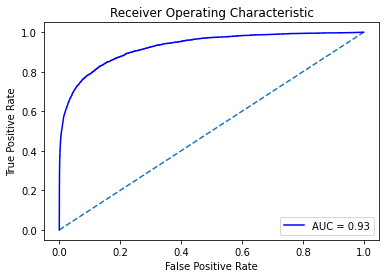

Training on fold 4 (Withholding Month: 17)
Train size: 498113 Test Size: 92427
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.989833	valid_1's auc: 0.914389
[400]	training's auc: 0.997932	valid_1's auc: 0.920477
[600]	training's auc: 0.999303	valid_1's auc: 0.921748
[800]	training's auc: 0.999684	valid_1's auc: 0.92194
[1000]	training's auc: 0.999832	valid_1's auc: 0.921191
[1200]	training's auc: 0.999901	valid_1's auc: 0.920846
Early stopping, best iteration is:
[723]	training's auc: 0.999582	valid_1's auc: 0.922267
Training Set Classification Report


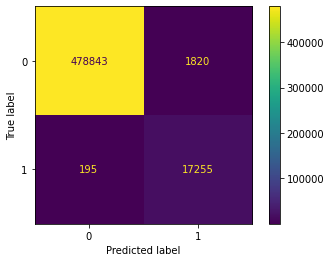

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    480663
           1       0.90      0.99      0.94     17450

    accuracy                           1.00    498113
   macro avg       0.95      0.99      0.97    498113
weighted avg       1.00      1.00      1.00    498113

Validation Set Classification Report


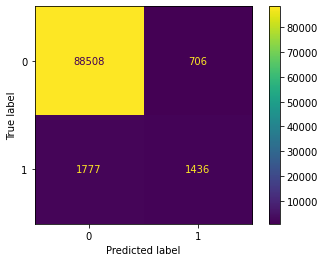

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     89214
           1       0.67      0.45      0.54      3213

    accuracy                           0.97     92427
   macro avg       0.83      0.72      0.76     92427
weighted avg       0.97      0.97      0.97     92427



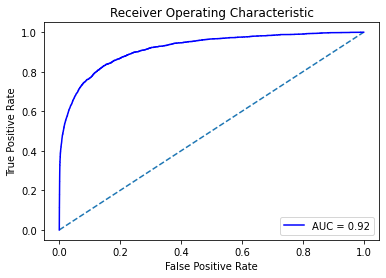

Training on fold 5 (Withholding Month: 14)
Train size: 421244 Test Size: 169296
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.991327	valid_1's auc: 0.91994
[400]	training's auc: 0.998288	valid_1's auc: 0.927688
[600]	training's auc: 0.99943	valid_1's auc: 0.929508
[800]	training's auc: 0.999743	valid_1's auc: 0.930226
[1000]	training's auc: 0.999863	valid_1's auc: 0.930539
[1200]	training's auc: 0.999917	valid_1's auc: 0.930632
[1400]	training's auc: 0.999945	valid_1's auc: 0.930584
[1600]	training's auc: 0.99996	valid_1's auc: 0.930444
Early stopping, best iteration is:
[1248]	training's auc: 0.999925	valid_1's auc: 0.930672
Training Set Classification Report


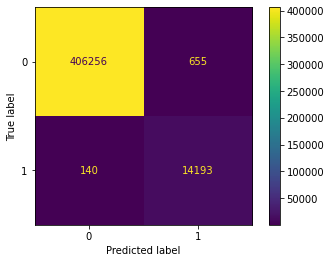

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    406911
           1       0.96      0.99      0.97     14333

    accuracy                           1.00    421244
   macro avg       0.98      0.99      0.99    421244
weighted avg       1.00      1.00      1.00    421244

Validation Set Classification Report


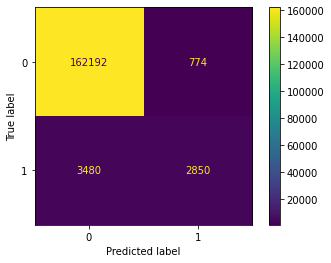

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    162966
           1       0.79      0.45      0.57      6330

    accuracy                           0.97    169296
   macro avg       0.88      0.72      0.78    169296
weighted avg       0.97      0.97      0.97    169296



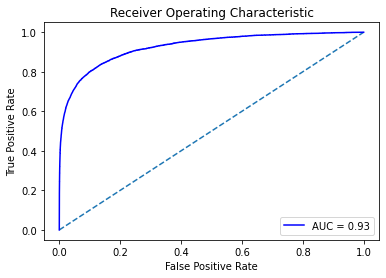

--------------------------------------------------
Mean AUC: 0.9190747879327897
--------------------------------------------------


In [27]:
folds = GroupKFold(n_splits=5)

y_oof = np.zeros(y.shape[0])
y_test_pred = np.zeros(test.shape[0])

weights = y.value_counts(normalize = True).min() / y.value_counts(normalize = True)
train_weights = pd.DataFrame(y.rename('old_target')).merge(
    weights, 
    how = 'left', 
    left_on = 'old_target', 
    right_on = weights.index)['isFraud'].values

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups=X['Month'])):
    month = X.iloc[test_idx]['Month'].iloc[0]
    print(f'Training on fold {fold + 1} (Withholding Month: {month})')
    print(f'Train size: {len(trn_idx)} Test Size: {len(test_idx)}')

    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx], weight=train_weights[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx], weight=train_weights[test_idx])

    clf = lgb.train(
        hyper_parameters, 
        trn_data, 10000, 
        valid_sets = [trn_data, val_data], 
        verbose_eval=200, 
        early_stopping_rounds=500
    )
    
    # predict validation
    y_pred = clf.predict(X.iloc[test_idx])
    y_oof[test_idx] = y_pred
    
    # predict test
    y_test_pred += clf.predict(test) / folds.n_splits
    
    # Confusion matrix for train and validation
    
    print('Training Set Classification Report')
    threshold = 0.70
    y_train_pred = (clf.predict(X.iloc[trn_idx]) > threshold).astype('float')
    make_classification_report(y_test=y[trn_idx], y_pred=y_train_pred)
    
    print('Validation Set Classification Report')
    y_valid_pred = (y_pred > threshold).astype('float')
    make_classification_report(y_test=y[test_idx], y_pred=y_valid_pred)
    
    build_roc(y[test_idx], y_pred)

    feature_importances[f'fold_{fold + 1}'] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])

print('-' * 50)
print('Mean AUC:', np.mean(aucs))
print('-' * 50)

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')
sub.isFraud = y_test_pred
sub.to_csv('sub_lgb.csv', index=False)